## Mask R-CNN - Inspect Weights of a Trained Model

This notebook includes code and visualizations to test, debug, and evaluate the Mask R-CNN model.

In [1]:
import os
import sys
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import keras

# Root directory of the project
ROOT_DIR = "D:/HARI/__open_source__/Mask_RCNN"

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library

from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

%matplotlib inline 


Using TensorFlow backend.


In [2]:
# Directory to save logs and trained model
MODEL_DIR = "D:/HARI/__RL_Dev__/__Backend_RL__/yolo_utils/models"

# Local path to trained weights file
MODEL_PATH = os.path.join(MODEL_DIR, "yolo_UTL_east.h5")

sys.path.append("D:/HARI/_Combined_YOLO_Resnet_Ryo_")


## Configurations

## Notebook Preferences

In [ ]:
# Device to load the neural network on.
# Useful if you're training a model on the same 
# machine, in which case use CPU and leave the
# GPU for training.
DEVICE = "/cpu:0"  # /cpu:0 or /gpu:0

In [3]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Load Model

In [4]:
from keras import backend as K
from keras.utils import multi_gpu_model
from keras.models import load_model, Model
from keras.layers import Input

import tensorflow as tf
from keras import backend as K

from PIL import Image

# from yolo_utils.yolo3.model import yolo_eval, yolo_body, tiny_yolo_body
# from yolo_utils.yolo3.utils import letterbox_image

from Resnet import config as Resnet_Config
from Resnet.train import get_model
from Resnet.crop_bump import get_bump_position, Error_status
from Resnet.prepare_data import generate_datasets, load_and_preprocess_image


In [5]:
# from yolo import YOLO

# model_class = YOLO(process="UTL_east")
# model = model_class.yolo_model

model = get_model()
model.load_weights(filepath="D:/HARI/_Combined_YOLO_Resnet_Ryo_/Resnet/saved_model/modelepoch_98")


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "res_net_type_ii"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              multiple                  9472      
_________________________________________________________________
batch_normalization (BatchNo multiple                  256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) multiple                  0         
_________________________________________________________________
sequential (Sequential)      multiple                  353664    
_________________________________________________________________
sequential_4 (Sequential)    multiple                  2024448   
_________________________________________________________________
sequential_9 (Sequential)    multiple                  12397568  

## Review Weight Stats

In [6]:
def find_trainable_layer(layer):
        """If a layer is encapsulated by another layer, this function
        digs through the encapsulation and returns the layer that holds
        the weights.
        """
        if layer.__class__.__name__ == 'TimeDistributed':
            return find_trainable_layer(layer.layer)
        return layer

def get_trainable_layers(model):
    """Returns a list of layers that have weights."""
    layers = []
    # Loop through all layers
    for l in model.layers:
        # If layer is a wrapper, find inner trainable layer
        l = find_trainable_layer(l)
        # Include layer if it has weights
        if l.get_weights():
            layers.append(l)
    return layers

def display_table(table):
    import IPython.display
    """Display values in a table format.
    table: an iterable of rows, and each row is an iterable of values.
    """
    html = ""
    for row in table:
        row_html = ""
        for col in row:
            row_html += "<td>{:40}</td>".format(str(col))
        html += "<tr>" + row_html + "</tr>"
    html = "<table>" + html + "</table>"
    IPython.display.display(IPython.display.HTML(html))

def display_weight_stats(model):
    """Scans all the weights in the model and returns a list of tuples
    that contain stats about each weight.
    """
    layers = get_trainable_layers(model)
    table = [["WEIGHT NAME", "SHAPE", "MIN", "MAX", "STD"]]
    for l in layers:
        weight_values = l.get_weights()  # list of Numpy arrays
        weight_tensors = l.weights  # list of TF tensors
        for i, w in enumerate(weight_values):
            weight_name = weight_tensors[i].name
            # Detect problematic layers. Exclude biases of conv layers.
            alert = ""
            if w.min() == w.max() and not (l.__class__.__name__ == "Conv2D" and i == 1):
                alert += "<span style='color:red'>*** dead?</span>"
            if np.abs(w.min()) > 1000 or np.abs(w.max()) > 1000:
                alert += "<span style='color:red'>*** Overflow?</span>"
            # Add row
            table.append([
                weight_name + alert,
                str(w.shape),
                "{:+9.4f}".format(w.min()),
                "{:+10.4f}".format(w.max()),
                "{:+9.4f}".format(w.std()),
            ])
    display_table(table)
    

In [7]:
# Show stats of all trainable weights    
display_weight_stats(model)

WEIGHT NAME,SHAPE,MIN,MAX,STD
conv2d/kernel:0,"(7, 7, 3, 64)",-0.0430,+0.0429,+0.0247
conv2d/bias:0,"(64,)",-0.0000,+0.0000,+0.0000
batch_normalization/gamma:0,"(64,)",+0.9996,+1.0003,+0.0001
batch_normalization/beta:0,"(64,)",-0.0004,+0.0004,+0.0001
batch_normalization/moving_mean:0,"(64,)",-0.1078,+0.1188,+0.0498
batch_normalization/moving_variance:0,"(64,)",+0.0002,+0.0108,+0.0023
sequential/bottle_neck/conv2d_1/kernel:0,"(1, 1, 64, 64)",-0.2165,+0.2165,+0.1250
sequential/bottle_neck/conv2d_1/bias:0,"(64,)",-0.0000,+0.0000,+0.0000
sequential/bottle_neck/batch_normalization_1/gamma:0,"(64,)",+0.9996,+1.0003,+0.0001
sequential/bottle_neck/batch_normalization_1/beta:0,"(64,)",-0.0004,+0.0002,+0.0001


# Histograms of Weights

TODO: cleanup this part

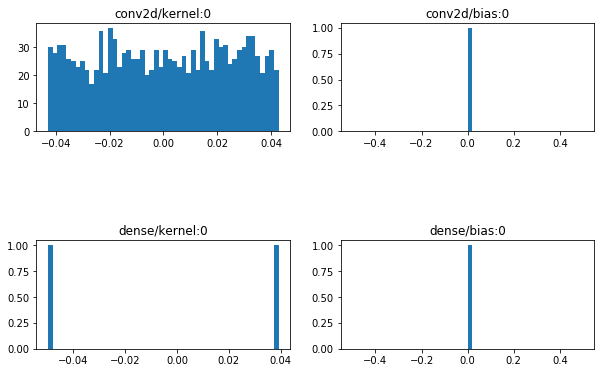

In [10]:
# Pick layer types to display
LAYER_TYPES = ['conv2d', 'dense', 'conv2dtranspose']

# Get layers
layers = get_trainable_layers(model)
layers = list(filter(lambda l: l.__class__.__name__.lower() in LAYER_TYPES, 
                layers))

# Display Histograms
fig, ax = plt.subplots(len(layers), 2, figsize=(10, 3*len(layers)),
                       gridspec_kw={"hspace":1})
for l, layer in enumerate(layers):
    weights = layer.get_weights()
    for w, weight in enumerate(weights):
        tensor = layer.weights[w]
        ax[l, w].set_title(tensor.name)
        _ = ax[l, w].hist(weight[w].flatten(), 50)
